## 🛳️ Titanic — CatBoost Classifier

Projeto de classificação supervisionada para previsão de sobrevivência no Titanic utilizando CatBoost, com foco em estabilidade estatística, comparação justa entre estratégias de tuning e decisão orientada por evidência.

### Destaques

* Pipeline reprodutível com pré-processamento versionado via joblib.
* Avaliação de quatro abordagens: Baseline, Random Search, Refine e Otimização Bayesiana.
* Métricas principais: ROC-AUC e Acurácia, com validação cruzada 10-fold.
* Otimização automática de threshold, permitindo ajuste fino da decisão.
* Relatório estatístico automatizado, incluindo teste de significância (t-test pareado) e análise de estabilidade.



## 1. Bibliotecas

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import time

from scipy.stats import ttest_rel


# sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin, clone

# CATBoost
from catboost import CatBoostClassifier


# Importações locais
from setup_notebook import setup_path
setup_path()
from src.model_utils import *
from src.preprocess_utils_tic import preprocessador_titanic

from src.plot_metrica_class import *



## 2. Dataload & Preprocessamento com joblib

In [2]:
BASE = Path.cwd().parent   
# =====================================================
# ⚙️ 0. carregamento dos preprocessador 
# =====================================================
temp = joblib.load(BASE /'src'/'preprocess_Titanic_v1.2.joblib')
PP2=temp['preprocessador']

# # =====================================================
# # 📁 1. Leitura dos dados & Separação das bases
# # =====================================================

DATA_DIR = BASE / "data" / "raw"
X_train = pd.read_csv(DATA_DIR / "X_train_raw.csv").reset_index(drop=True)
X_test  = pd.read_csv(DATA_DIR / "X_test_raw.csv")
y_train = pd.read_csv(DATA_DIR / "y_train_raw.csv").values.ravel()
y_test  = pd.read_csv(DATA_DIR / "y_test_raw.csv")


# # =====================================================
# #  🤖 3.Definição dos Modelos
# # =====================================================

# -----------------------
# Baseline
# -----------------------
model_CBT0 = CatBoostClassifier(loss_function='Logloss',eval_metric='AUC',random_state=42,
                               verbose=False,early_stopping_rounds=100)
pipe_CBT0 = pipe_models(model_CBT0, PP2)


DATA_MODELS= BASE /"models"
pipe_CBT1 = joblib.load(DATA_MODELS / 'modelo_CBT_final_randsearch.roc_auc_v12.joblib')
pipe_CBT2 = joblib.load(DATA_MODELS / 'modelo_CBT_final_refine.roc_auc_v12.joblib')
pipe_CBT3 = joblib.load(DATA_MODELS / 'modelo_CBT_final_bayes.roc_auc_v12.joblib')

## 3.Treinamento

In [3]:
# Baseline
s0 = cross_val_score(pipe_CBT0 , X_train, y_train, cv=10)

# 2. Testa a performance 
pipe_CBT0.fit(X_train, y_train)
# 3.Otimização de Threshold
best_t_cbt0, score_cbt0 = best_threshold(pipe_CBT0, X_test, y_test)

y_pred=pipe_CBT0.predict(X_test)
print(f"{'='*70}")
print(f"🎯 CBT(Baseline) | cvscores : {s0.mean():.4f} ± {s0.std():.4f}")
print(f"{'='*70}")
print(f"📊 Acurácia no Teste: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📋 Relatório de Classificação:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 Matriz de Confusão:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")

🎯 Melhor Threshold: 0.650
📈 Melhor Acurácia (Test): 0.8284
🎯 CBT(Baseline) | cvscores : 0.8523 ± 0.0529
📊 Acurácia no Teste: 0.8172

📋 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       157
           1       0.82      0.72      0.77       111

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

🎯 Matriz de Confusão:
               Previsto 0   Previsto 1
Real 0         139         18         
Real 1         31          80         
──────────────────────────────────────────────────────────────────────


In [4]:
# CBT1
s1= cross_val_score(pipe_CBT1 , X_train, y_train, cv=10)

# 2. Testa a performance 
pipe_CBT1.fit(X_train, y_train)

# 3.Otimização de Threshold
best_t_cbt1, score_cbt1 = best_threshold(pipe_CBT1, X_test, y_test)

y_pred1=pipe_CBT1.predict(X_test)
print(f"{'='*70}")
print(f"🎯 CBT 1 | cvscores : {s1.mean():.4f} ± {s1.std():.4f}")
print(f"{'='*70}")
print(f"📊 Acurácia no Teste: {accuracy_score(y_test, y_pred1):.4f}")
print(f"\n📋 Relatório de Classificação:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 Matriz de Confusão:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")

🎯 Melhor Threshold: 0.440
📈 Melhor Acurácia (Test): 0.8134
🎯 CBT 1 | cvscores : 0.8460 ± 0.0508
📊 Acurácia no Teste: 0.8134

📋 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       157
           1       0.82      0.72      0.77       111

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

🎯 Matriz de Confusão:
               Previsto 0   Previsto 1
Real 0         139         18         
Real 1         31          80         
──────────────────────────────────────────────────────────────────────


In [5]:
#CBT2
s2= cross_val_score(pipe_CBT2 , X_train, y_train, cv=10)
# 2. Testa a peCBTormance 
pipe_CBT2.fit(X_train, y_train)

# 3.Otimização de Threshold
best_t_cbt2, score_cbt2 = best_threshold(pipe_CBT2, X_test, y_test)

y_pred2=pipe_CBT2.predict(X_test)
print(f"{'='*70}")
print(f"🎯 CBT 2 | cvscores : {s2.mean():.4f} ± {s2.std():.4f}")
print(f"{'='*70}")
print(f"📊 Acurácia no Teste: {accuracy_score(y_test, y_pred2):.4f}")
print(f"\n📋 Relatório de Classificação:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 Matriz de Confusão:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")

🎯 Melhor Threshold: 0.450
📈 Melhor Acurácia (Test): 0.8246
🎯 CBT 2 | cvscores : 0.8460 ± 0.0466
📊 Acurácia no Teste: 0.8246

📋 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       157
           1       0.82      0.72      0.77       111

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

🎯 Matriz de Confusão:
               Previsto 0   Previsto 1
Real 0         139         18         
Real 1         31          80         
──────────────────────────────────────────────────────────────────────


In [6]:
#CBT3
s3= cross_val_score(pipe_CBT3 , X_train, y_train, cv=10)

# 2. Testa a performance 
pipe_CBT3.fit(X_train, y_train)

# 3.Otimização de Threshold
best_t_cbt3, score_cbt3 = best_threshold(pipe_CBT3, X_test, y_test)

y_pred3=pipe_CBT3.predict(X_test)
print(f"{'='*70}")
print(f"🎯 CBT 3 | cvscores : {s3.mean():.4f} ± {s3.std():.4f}")
print(f"{'='*70}")
print(f"📊 Acurácia no Teste: {accuracy_score(y_test, y_pred3):.4f}")
print(f"\n📋 Relatório de Classificação:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 Matriz de Confusão:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")

🎯 Melhor Threshold: 0.420
📈 Melhor Acurácia (Test): 0.8284
🎯 CBT 3 | cvscores : 0.8539 ± 0.0535
📊 Acurácia no Teste: 0.8246

📋 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       157
           1       0.82      0.72      0.77       111

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

🎯 Matriz de Confusão:
               Previsto 0   Previsto 1
Real 0         139         18         
Real 1         31          80         
──────────────────────────────────────────────────────────────────────


In [7]:

# Calcula os scores de validação cruzada para cada modelo(acc)
s0_acc = cross_val_score(pipe_CBT0, X_train, y_train, cv=10)
s1_acc = cross_val_score(pipe_CBT1, X_train, y_train, cv=10)
s2_acc = cross_val_score(pipe_CBT2, X_train, y_train, cv=10)
s3_acc = cross_val_score(pipe_CBT3, X_train, y_train, cv=10)

score0 = pipe_CBT0.score(X_test, y_test)
score1 = pipe_CBT1.score(X_test, y_test)
score2 = pipe_CBT2.score(X_test, y_test)
score3 = pipe_CBT3.score(X_test, y_test)

y_prob0 = pipe_CBT0.predict_proba(X_test)[:, 1]
y_prob1 = pipe_CBT1.predict_proba(X_test)[:, 1]
y_prob2 = pipe_CBT2.predict_proba(X_test)[:, 1]
y_prob3 = pipe_CBT3.predict_proba(X_test)[:, 1]



# # 1. Preparação dos Dados de Performance
models_list = [
    ('Modelo 0 ( Base )', pipe_CBT0, s0, s0_acc, y_prob0, best_t_cbt0),
    ('Modelo 1 (Random)', pipe_CBT1, s1, s1_acc, y_prob1, best_t_cbt1),
    ('Modelo 2 (Refine)', pipe_CBT2, s2, s2_acc, y_prob2, best_t_cbt2),
    ('Modelo 3 (Bayes )', pipe_CBT3, s3, s3_acc, y_prob3, best_t_cbt3,)
]

df_results,W = gerar_relatorio_estatistico(models_list,X_train, y_train,X_test, y_test)

                      RELATÓRIO DE DESEMPENHO E ESTABILIDADE ESTATÍSTICA                       
      Modelo         CV ROC-AUC        CV ACC       Test ROC-AUC   Test ACC (0.5)   Best Thresh    Test ACC (Opt)
Modelo 0 ( Base ) 0.8523 ± 0.0529 0.8523 ± 0.0529      0.8811          0.8172          0.650           0.8284    
Modelo 1 (Random) 0.8460 ± 0.0508 0.8460 ± 0.0508      0.8730          0.8134          0.440           0.8134    
Modelo 2 (Refine) 0.8460 ± 0.0466 0.8460 ± 0.0466      0.8739          0.8246          0.450           0.8246    
Modelo 3 (Bayes ) 0.8539 ± 0.0535 0.8539 ± 0.0535      0.8678          0.8246          0.420           0.8284    

                     ANÁLISE DE SIGNIFICÂNCIA ESTATÍSTICA (T-TEST PAREADO)                     
Modelo 1 (Random) vs Modelo 2 (Refine): p-value = 1.0000 | Diferença Significativa? NÃO
Modelo 1 (Random) vs Modelo 3 (Bayes ): p-value = 0.2147 | Diferença Significativa? NÃO
Modelo 2 (Refine) vs Modelo 3 (Bayes ): p-value = 0.3467 | Di

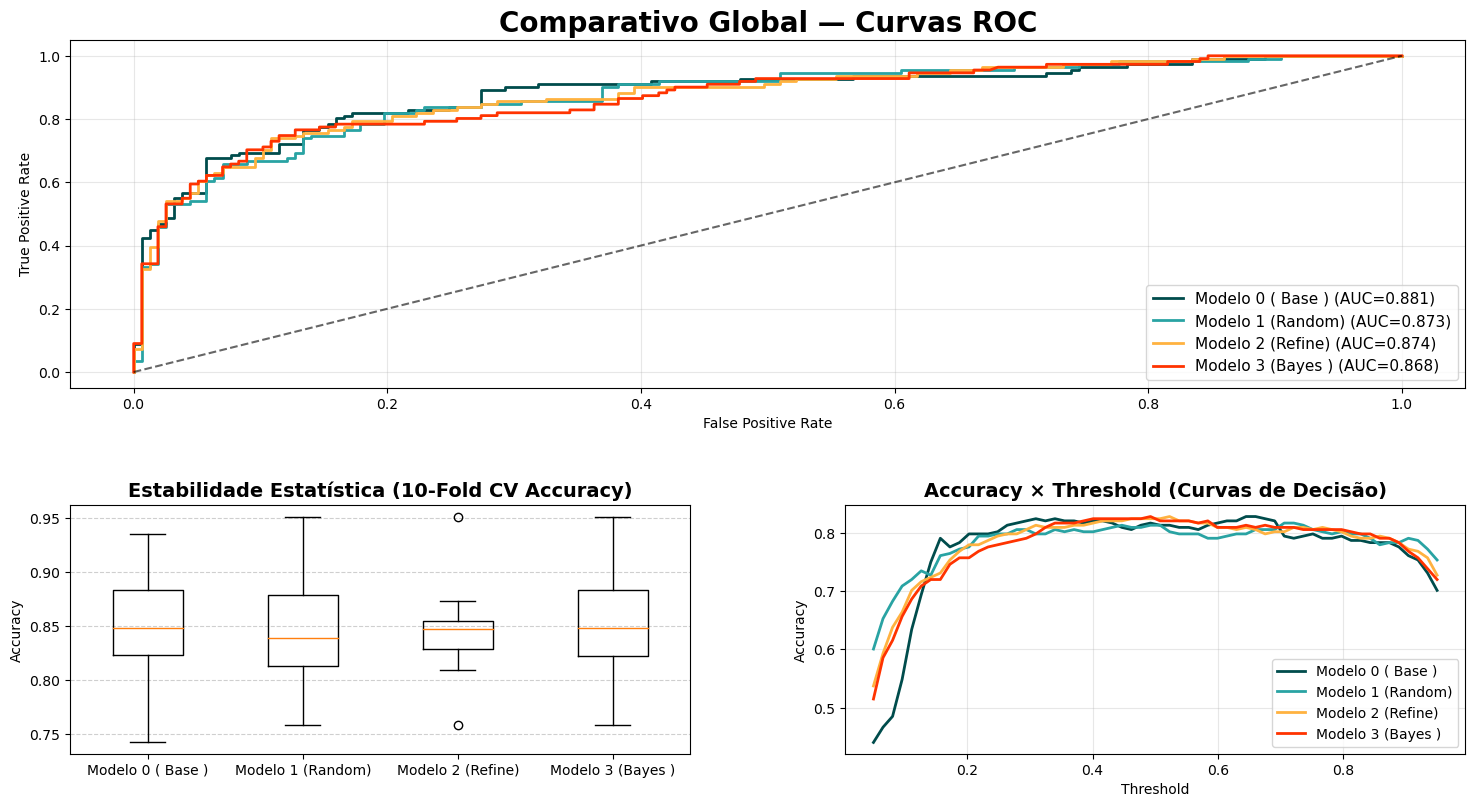

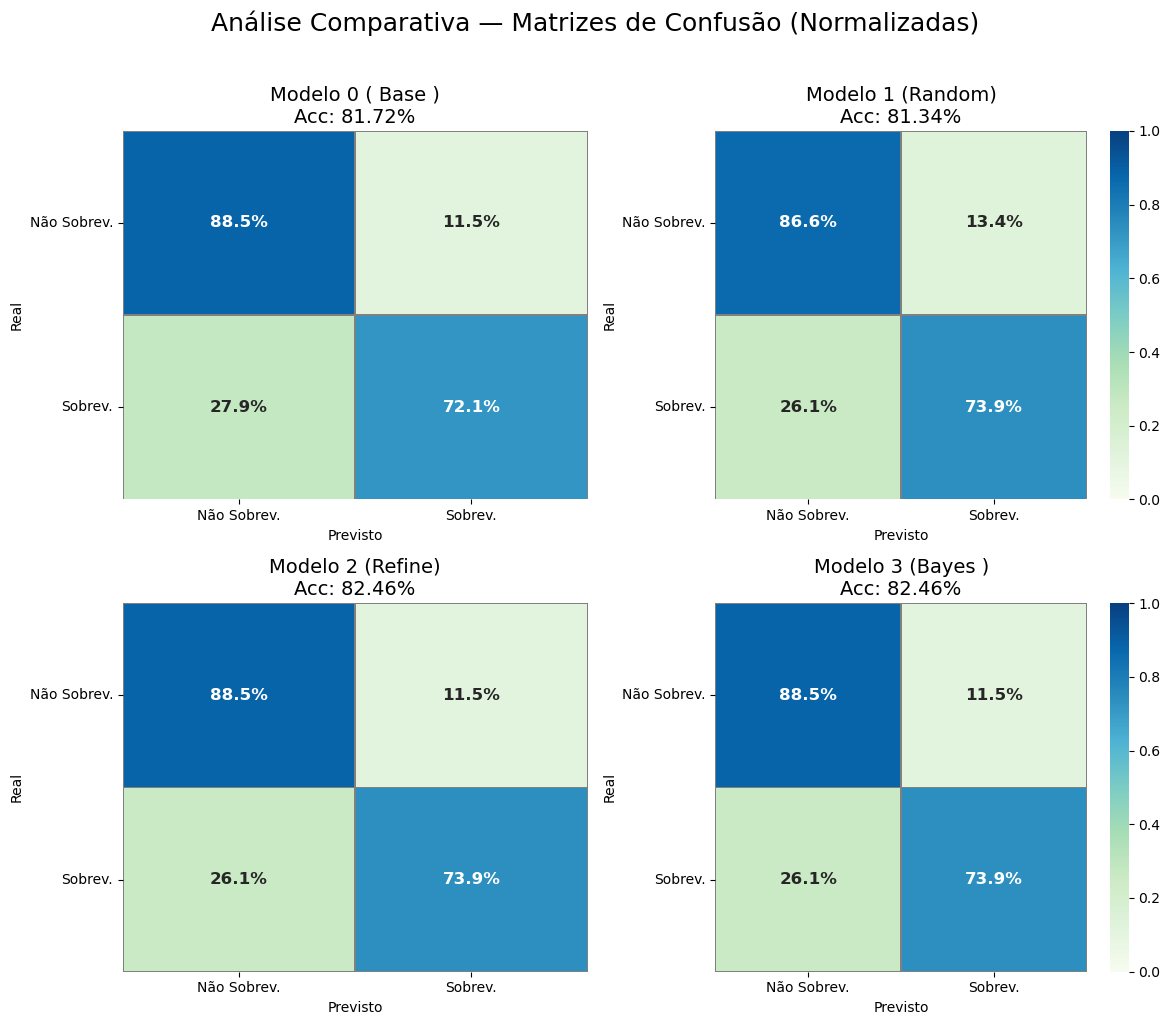

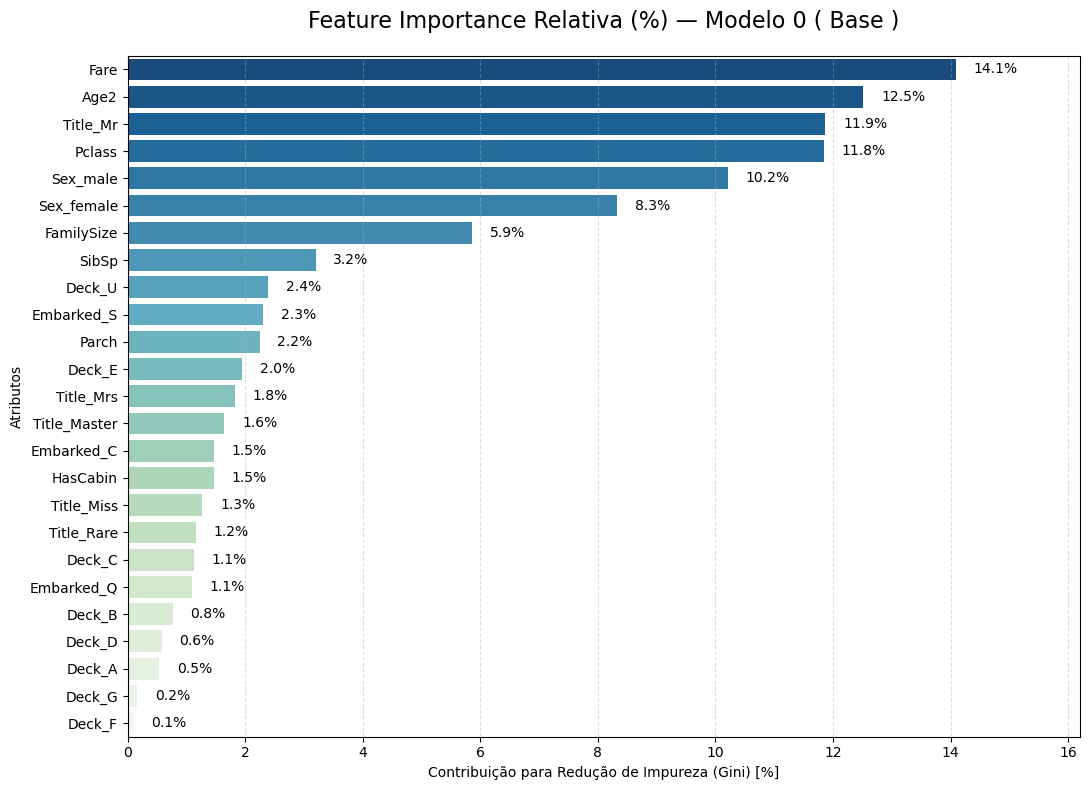


#Processo finalizado em: 16:39:16


In [8]:
importances=model_evaluation_grid(
    models_list=models_list,
    X_test=X_test,
    y_test=y_test,
    best_model_pipeline=W[1],
    best_model_name=W[0]
)

## Considerações finais

A análise dos resultados evidencia que, para o CatBoost aplicado ao problema de classificação do Titanic, a qualidade do pré-processamento e a calibração do threshold tiveram impacto mais relevante do que a otimização agressiva de hiperparâmetros.

### Síntese dos resultados

* O CatBoost Baseline apresentou desempenho sólido já na configuração inicial, com ROC-AUC ≈ 0.85 em validação cruzada e ROC-AUC de 0.8811 em teste, superando ou igualando os modelos otimizados.

* Os modelos ajustados por Random Search, refinamento manual e otimização Bayesiana não apresentaram ganhos estatisticamente significativos em relação ao baseline, indicando retorno marginal decrescente das estratégias de busca.

  * O modelo Bayesiano atingiu desempenho competitivo, mas sem superar de forma consistente o baseline em teste;
  * O modelo refinado manteve boa estabilidade, porém sem vantagem estatística clara.

### Análise de generalização (validação cruzada)

A comparação entre validação cruzada e teste indica que:

* O CatBoost Baseline apresenta alta estabilidade e excelente capacidade de generalização, com baixa discrepância entre CV e teste;
* As diferenças entre os modelos otimizados não são estatisticamente significativas, conforme confirmado pelos testes t pareados;
* O CatBoost mostrou-se robusto à variabilidade amostral, mesmo sem ajustes finos extensivos.

### Interpretação e relevância das variáveis

A análise de importância das variáveis confirma padrões consistentes com o domínio do problema:

* Tarifa (Fare), idade, título social, classe socioeconômica e sexo são os principais fatores associados à sobrevivência;
* Variáveis como tamanho da família, cabine e deck atuam de forma complementar;
* A distribuição de importâncias sugere que o modelo captura tanto efeitos dominantes quanto interações secundárias relevantes, sem sinais de sobreajuste.

### Conclusões práticas

* O CatBoost Baseline, aliado a um pré-processamento bem estruturado, mostrou-se a melhor escolha global, combinando desempenho, estabilidade estatística e simplicidade operacional.
* O ajuste de threshold (0.65) foi fundamental para elevar a acurácia de 0.8172 para 0.8284, reforçando a importância da calibração pós-treinamento.
* Estratégias de otimização mais complexas não produziram ganhos proporcionais, indicando que o modelo já opera próximo de seu ótimo neste conjunto de dados.


### Comparação final entre algoritmos

Apesar do bom desempenho do CatBoost, a análise comparativa indica que o** Random Forest otimizado** apresentou resultados superiores no conjunto de teste, consolidando-se como o modelo vencedor global do estudo.

Em termos quantitativos:

* Random Forest otimizado🏆

  * Test ROC-AUC ≈ 0.89
  * Acurácia otimizada ≈ 0.84
  * Excelente estabilidade, com baixa discrepância entre validação cruzada e teste.

* CatBoost (Baseline vencedor)

  * Test ROC-AUC = 0.8811
  * Acurácia otimizada = 0.8284
  * Desempenho consistente e robusto, porém inferior ao Random Forest na métrica principal de decisão.

A diferença entre os modelos não é extrema, ela se mostra consistente e favorável ao Random Forest, especialmente em ROC-AUC, métrica central para avaliação da capacidade discriminativa.